In [1]:
import os
from pathlib import Path
from tqdm import tqdm
import pickle

from qiskit import transpile
from qiskit.circuit.random import random_circuit
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BackendEstimator, Estimator

from tqdm.notebook import tqdm_notebook

from blackwater.data.utils import get_backend_properties_v1, encode_pauli_sum_op
from blackwater.exception import BlackwaterException

from qiskit import QuantumCircuit, transpile
from qiskit.opflow import PauliSumOp
from qiskit.primitives import BaseEstimator, EstimatorResult
from qiskit.providers import JobV1 as Job, Options, BackendV2, Backend, BackendV1
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.fake_provider import FakeLimaV2, FakeLima, ConfigurableFakeBackend
from qiskit.opflow import I, X, Z, Y
from qiskit.algorithms.minimum_eigensolvers import VQE, VQEResult
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

from blackwater.data.utils import generate_random_pauli_sum_op, get_backend_properties_v1
from blackwater.library.learning.estimator import learning, EmptyProcessor, TorchLearningModelProcessor
from qiskit_aer import AerSimulator
import itertools
import numpy as np
from mbd_utils import cal_all_z_exp

from mlp import encode_data, MLP1
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import random

ModuleNotFoundError: No module named 'blackwater.library.temp'

In [ ]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

backend_noisy = AerSimulator.from_backend(backend) # Noisy
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [ ]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [ ]:
ansatz = TwoLocal(num_qubits=4, rotation_blocks='rx', entanglement_blocks='cx', reps=3)
ansatz.decompose().draw('mpl')

In [ ]:
from qiskit.result import marginal_counts
from qiskit import execute
from qiskit_aer import QasmSimulator

qasm_sim = QasmSimulator()

def get_all_z_exp_wo_shot_noise(circuit, marginal_over=None):
    circuit_copy = circuit.copy()
    circuit_copy.remove_final_measurements()
    circuit_copy.save_density_matrix()

    def int_to_bin(n, num_bits=4):
        if n < 2**num_bits:
            binary_str = bin(n)[2:]
            return binary_str.zfill(num_bits)
        else:
            raise ValueError

    # print(circuit_copy.draw())
    circuit_copy = transpile(circuit_copy, backend=backend_noisy, optimization_level=3)
    job = qasm_sim.run(circuit_copy)
    # job = execute(circuit_copy, QasmSimulator(), backend_options={'method': 'statevector'})
    probs = np.real(np.diag(job.result().results[0].data.density_matrix))
    probs = {int_to_bin(i, num_bits=4): p for i, p in enumerate(probs)}

    if marginal_over:
        probs = marginal_counts(probs, indices=marginal_over)

    exp_val = 0
    for key, prob in probs.items():
        num_ones = key.count('1')
        exp_val += (-1) ** num_ones * prob

    return exp_val

In [3]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    meas_basis = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
                meas_basis.append(entry['meas_basis'])
    return circuits, ideal_exp_vals, noisy_exp_vals, meas_basis

In [4]:
circuits, ideal_exp_vals, noisy_exp_vals, meas_bases = load_circuits('./data/vqe/', '.pk')
print(len(circuits))

100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

128


In [59]:
sep = 50
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals, train_meas_bases = circuits[:sep], ideal_exp_vals[:sep], noisy_exp_vals[:sep], meas_bases[:sep]
test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, test_meas_bases = circuits[sep:], ideal_exp_vals[sep:], noisy_exp_vals[sep:], meas_bases[sep:]

# train_noisy_exp_vals = [x[0] for x in train_noisy_exp_vals]
# test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals]
train_observables = [encode_pauli_sum_op(SparsePauliOp(basis))[0] for basis in train_meas_bases]
test_observables = [encode_pauli_sum_op(SparsePauliOp(basis))[0] for basis in test_meas_bases]
X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=1, meas_bases=train_observables)
X_test, y_test = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=1, meas_bases=test_observables)

In [60]:
BATCH_SIZE = 32
fix_random_seed(0)
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 0


In [62]:
fix_random_seed(0)
model = MLP1(
    input_size=68,
    output_size=1,
    hidden_size=64
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                            'min',
                              factor=0.1,
                              patience=15,
                              verbose=True,
                              min_lr=0.00001)

random seed fixed to 0


In [63]:
fix_random_seed(0)

train_losses = []
test_losses = []

N_EPOCHS = 50

progress = tqdm(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    test_loss = 0.0
    model.eval()
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

    scheduler.step(test_loss)

    if epoch >= 1:
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(test_losses[-1], 5)}")
        progress.refresh()

random seed fixed to 0


0.00122, 0.00041:  88%|████████▊ | 44/50 [00:07<00:01,  5.78it/s]

Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.


0.0012, 0.00042: 100%|██████████| 50/50 [00:08<00:00,  5.62it/s] 


In [64]:
# sep = 20 * 64
# train_circuits, train_ideal_exp_vals, train_noisy_exp_vals, train_meas_bases = circuits[:sep], ideal_exp_vals[:sep], noisy_exp_vals[:sep], meas_bases[:sep]
#
# print(len(train_circuits))
#
# train_observables = [encode_pauli_sum_op(SparsePauliOp(basis))[0] for basis in train_meas_bases]
# train_noisy_exp_vals_copy = [x[0][0] for x in train_noisy_exp_vals]
# X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals_copy, num_qubits=1, meas_bases=train_observables)
#
# BATCH_SIZE = 32
# fix_random_seed(0)
# test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

In [65]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# rfr_tree_list = []
# rfr = RandomForestRegressor(n_estimators=100)
# rfr.fit(X_train, y_train)
# rfr_tree_list.append(rfr)

In [66]:
from qiskit.quantum_info import Operator
qc = QuantumCircuit(2)
qc.x(0)
qc.id(1)

Operator(qc)
# XI

Operator([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [67]:
I ^X

PauliOp(Pauli('IX'), coeff=1.0)

In [68]:
(I ^ X).to_matrix()

array([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

In [72]:
processor = TorchLearningModelProcessor(
    model=model,
    backend=backend
)

str2opflow = {
    'I': I,
    'X': X,
    'Y': Y,
    'Z': Z,
}

coefficent = np.random.uniform(-1, 1, size=10)
operator_components = np.random.choice(train_meas_bases, size=2).tolist()+np.random.choice(test_meas_bases, size=8).tolist()

operator_components_opflow = []
for op_component in operator_components:
    op_f = 1
    for op_str in list(op_component):
        op_f = str2opflow[op_str] ^ op_f
    operator_components_opflow.append(op_f)

# print(operator_components_opflow)
operator = np.dot(coefficent, operator_components_opflow)
# print(operator)

ansatz = TwoLocal(num_qubits=3, rotation_blocks="ry", entanglement_blocks="cz")

learning_estimator = learning(Estimator, processor=processor, backend=backend, skip_transpile=True)
# estimator = learning_estimator()
estimator = Estimator()

history = []

slsqp = SLSQP(maxiter=100)
vqe = VQE(estimator, ansatz, slsqp, callback=lambda a, b, c, d: history.append(c))
result = vqe.compute_minimum_eigenvalue(operator)

<Axes: >

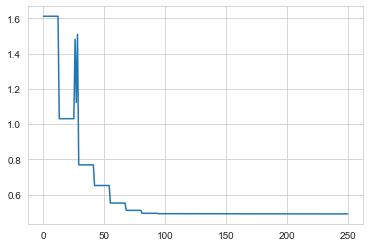

In [79]:
import seaborn as sns
sns.lineplot(history)